In [1]:
from pathlib import Path
import os

import cv2
import numpy as np
import json
import random 
import matplotlib.pyplot as plt

In [2]:
base = Path("../../..")

YOLO_ROOT = base / "data/tracking/YOLO_baseline"
SRC_IMAGES_DIR = YOLO_ROOT / "images"
SRC_LABELS_DIR = YOLO_ROOT / "labels"

BALL_ROOT = base / "data/tracking/YOLO_ball"
BALL_IMAGES_DIR = BALL_ROOT / "images"
BALL_LABELS_DIR = BALL_ROOT / "labels"

for split in ["train", "val"]:
    (BALL_IMAGES_DIR / split).mkdir(parents=True, exist_ok=True)
    (BALL_LABELS_DIR / split).mkdir(parents=True, exist_ok=True)

# índice de la pelota en el dataset baseline
CLASS_BALL = 2

# en el nuevo dataset solo habrá 1 clase (pelota) → la ponemos como 0
OUT_CLASS_ID = 0


In [3]:
def load_yolo_labels(label_path: Path):
    """
    Lee un .txt formato YOLO: class x_center y_center width height (normalizados).
    Devuelve lista de tuplas (cls, x_c, y_c, w, h).
    """
    boxes = []
    if not label_path.exists():
        return boxes
    
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls = int(parts[0])
            x_c, y_c, w, h = map(float, parts[1:])
            boxes.append((cls, x_c, y_c, w, h))
    return boxes


def yolo_to_xyxy(box, img_w, img_h):
    """
    Convierte (cls, x_c, y_c, w, h) normalizado a (cls, x1, y1, x2, y2) en píxeles.
    """
    cls, x_c, y_c, w, h = box
    x_c *= img_w
    y_c *= img_h
    w *= img_w
    h *= img_h

    x1 = x_c - w / 2.0
    y1 = y_c - h / 2.0
    x2 = x_c + w / 2.0
    y2 = y_c + h / 2.0

    return cls, x1, y1, x2, y2


def generate_patches(h, w, overlap_frac=0.15):
    """
    Genera 4 parches (2x2) con un overlap (fracción) para evitar cortar la pelota.
    Devuelve lista de (x0, y0, x1, y1) en coordenadas de imagen.
    """
    base_w = w / 2.0
    base_h = h / 2.0
    overlap_x = overlap_frac * base_w
    overlap_y = overlap_frac * base_h

    patches = []
    for row in range(2):
        for col in range(2):
            x0 = col * base_w
            x1 = (col + 1) * base_w
            y0 = row * base_h
            y1 = (row + 1) * base_h

            # expandimos hacia el vecino para crear overlapping
            if col == 0:
                x0 = 0
                x1 = min(w, x1 + overlap_x)
            else:
                x0 = max(0, x0 - overlap_x)
                x1 = w

            if row == 0:
                y0 = 0
                y1 = min(h, y1 + overlap_y)
            else:
                y0 = max(0, y0 - overlap_y)
                y1 = h

            patches.append((int(round(x0)), int(round(y0)),
                            int(round(x1)), int(round(y1))))
    return patches


def project_balls_to_patch(ball_boxes_xyxy, patch_xyxy, out_class_id=OUT_CLASS_ID):
    """
    Proyecta los bounding boxes de la pelota en un patch dado.
    - ball_boxes_xyxy: lista de (cls, x1, y1, x2, y2) en coords de imagen.
    - patch_xyxy: (x0, y0, x1, y1) del patch en coords de imagen.
    
    Devuelve:
      - yolo_labels: lista de strings 'cls x_c y_c w h' (normalizado al patch)
      - patch_boxes_xyxy: lista de (cls, px1, py1, px2, py2) en coords del patch
    """
    x0, y0, x1, y1 = patch_xyxy
    patch_w = x1 - x0
    patch_h = y1 - y0
    if patch_w <= 0 or patch_h <= 0:
        return [], []

    yolo_labels = []
    patch_boxes_xyxy = []

    for cls, bx1, by1, bx2, by2 in ball_boxes_xyxy:
        # usamos el centro del bbox para decidir si pertenece al patch
        cx = (bx1 + bx2) / 2.0
        cy = (by1 + by2) / 2.0
        if not (x0 <= cx < x1 and y0 <= cy < y1):
            continue

        # recortamos el bbox al interior del patch
        nx1 = max(bx1, x0)
        ny1 = max(by1, y0)
        nx2 = min(bx2, x1)
        ny2 = min(by2, y1)

        bw = nx2 - nx1
        bh = ny2 - ny1
        if bw <= 1 or bh <= 1:
            continue

        # pasamos a coords relativas al patch
        px1 = nx1 - x0
        py1 = ny1 - y0
        px2 = nx2 - x0
        py2 = ny2 - y0

        patch_boxes_xyxy.append((out_class_id, px1, py1, px2, py2))

        # y ahora a formato YOLO normalizado (en el patch)
        bx_c = (px1 + px2) / 2.0
        by_c = (py1 + py2) / 2.0

        x_c_norm = bx_c / patch_w
        y_c_norm = by_c / patch_h
        w_norm = bw / patch_w
        h_norm = bh / patch_h

        # chequeo simple de que el centro esté dentro de [0,1]
        if not (0 < x_c_norm < 1 and 0 < y_c_norm < 1):
            continue

        yolo_labels.append(
            f"{out_class_id} {x_c_norm:.6f} {y_c_norm:.6f} {w_norm:.6f} {h_norm:.6f}"
        )

    return yolo_labels, patch_boxes_xyxy


In [4]:
def plot_random_example_with_patches(split="train", overlap_frac=0.15):
    src_img_dir = SRC_IMAGES_DIR / split
    src_lbl_dir = SRC_LABELS_DIR / split

    candidates = []
    for label_path in sorted(src_lbl_dir.glob("*.txt")):
        boxes = load_yolo_labels(label_path)
        if any(b[0] == CLASS_BALL for b in boxes):
            stem = label_path.stem
            img_path_jpg = src_img_dir / f"{stem}.jpg"
            img_path_png = src_img_dir / f"{stem}.png"
            img_path = None
            if img_path_jpg.exists():
                img_path = img_path_jpg
            elif img_path_png.exists():
                img_path = img_path_png
            if img_path is not None:
                candidates.append((img_path, boxes))

    if not candidates:
        print(f"No se encontraron imágenes con pelota en split='{split}'.")
        return

    img_path, boxes = random.choice(candidates)
    print(f"Ejemplo debug: {img_path}")

    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        print("No se pudo leer la imagen.")
        return

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]

    ball_boxes = [b for b in boxes if b[0] == CLASS_BALL]
    ball_xyxy = [yolo_to_xyxy(b, w, h) for b in ball_boxes]
    patches = generate_patches(h, w, overlap_frac=overlap_frac)

    # Figura 1: imagen original con bbox de pelota + patches
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(img_rgb)

    # bbox de pelota
    for cls, x1, y1, x2, y2 in ball_xyxy:
        rect = plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor="lime", facecolor="none"
        )
        ax.add_patch(rect)

    # rectángulos de los patches
    for (x0, y0, x1, y1) in patches:
        rect = plt.Rectangle(
            (x0, y0), x1 - x0, y1 - y0,
            linewidth=1, edgecolor="yellow", linestyle="--", facecolor="none"
        )
        ax.add_patch(rect)

    ax.set_title("Imagen original + pelota + patches (2x2)")
    ax.axis("off")
    plt.show()

    # Figura 2: los 4 patches con bboxes proyectados
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))

    for i, (x0, y0, x1, y1) in enumerate(patches):
        patch = img_rgb[y0:y1, x0:x1]
        _, patch_boxes = project_balls_to_patch(ball_xyxy, (x0, y0, x1, y1))

        ax = axes[i // 2][i % 2]
        ax.imshow(patch)

        for cls, px1, py1, px2, py2 in patch_boxes:
            rect = plt.Rectangle(
                (px1, py1), px2 - px1, py2 - py1,
                linewidth=2, edgecolor="red", facecolor="none"
            )
            ax.add_patch(rect)

        ax.set_title(f"Patch {i}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


Ejemplo debug: ../../../data/tracking/YOLO_baseline/images/train/SNMOT-103_000724.jpg


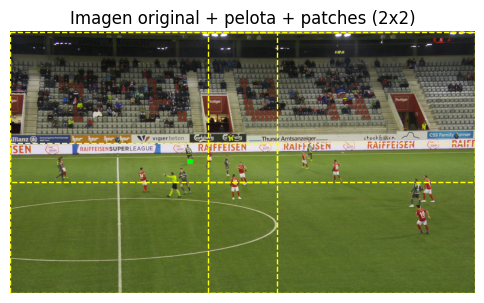

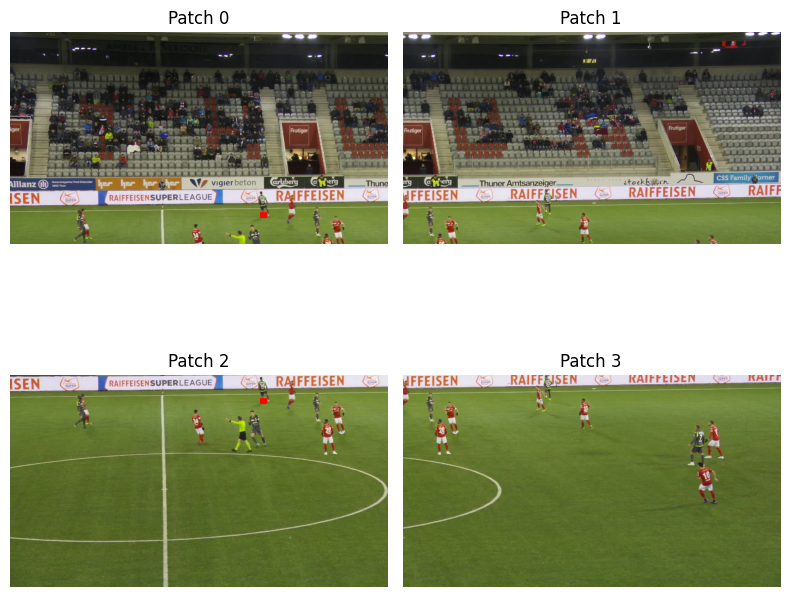

In [5]:
plot_random_example_with_patches(split="train", overlap_frac=0.15)


In [ ]:
def get_image_path_for_label(label_path: Path, images_dir: Path):
    """
    Dado un .txt de labels, devuelve el path de la imagen correspondiente
    probando extensiones comunes.
    """
    stem = label_path.stem
    for ext in [".jpg", ".jpeg", ".png"]:
        img_path = images_dir / f"{stem}{ext}"
        if img_path.exists():
            return img_path
    return None


def process_split(split, overlap_frac=0.15):
    src_img_dir = SRC_IMAGES_DIR / split
    src_lbl_dir = SRC_LABELS_DIR / split
    dst_img_dir = BALL_IMAGES_DIR / split
    dst_lbl_dir = BALL_LABELS_DIR / split

    label_files = sorted(src_lbl_dir.glob("*.txt"))

    num_frames_with_ball = 0
    num_patches_total = 0

    for label_path in label_files:
        boxes = load_yolo_labels(label_path)
        # nos quedamos solo con las labels de pelota
        ball_boxes = [b for b in boxes if b[0] == CLASS_BALL]
        if not ball_boxes:
            continue  # este frame no tiene pelota

        img_path = get_image_path_for_label(label_path, src_img_dir)
        if img_path is None:
            continue

        img_bgr = cv2.imread(str(img_path))
        if img_bgr is None:
            continue

        img_h, img_w = img_bgr.shape[:2]

        ball_xyxy = [yolo_to_xyxy(b, img_w, img_h) for b in ball_boxes]
        patches = generate_patches(img_h, img_w, overlap_frac=overlap_frac)

        for idx, patch_xyxy in enumerate(patches):
            x0, y0, x1, y1 = patch_xyxy
            patch_img = img_bgr[y0:y1, x0:x1]

            patch_h, patch_w = patch_img.shape[:2]
            if patch_h <= 0 or patch_w <= 0:
                continue

            # proyectamos las pelotas al patch correspondiente
            yolo_labels, _ = project_balls_to_patch(ball_xyxy, patch_xyxy)

            out_stem = f"{img_path.stem}_p{idx}"
            out_img_path = dst_img_dir / f"{out_stem}.jpg"
            out_lbl_path = dst_lbl_dir / f"{out_stem}.txt"

            # guardamos la imagen del patch
            cv2.imwrite(str(out_img_path), patch_img)

            # guardamos labels (puede quedar vacío → patch sin pelota)
            with open(out_lbl_path, "w") as f:
                for line in yolo_labels:
                    f.write(line + "\n")

            num_patches_total += 1

        num_frames_with_ball += 1

    print(f"Split: {split}")
    print(f"  Frames con pelota: {num_frames_with_ball}")
    print(f"  Patches generados (4 por frame con pelota): {num_patches_total}")


# Ejecutar transformación para train y val
for split in ["train", "val"]:
    process_split(split, overlap_frac=0.15)




Split: train
  Frames con pelota: 31661
  Patches generados (4 por frame con pelota): 126644
Split: val
  Frames con pelota: 8573
  Patches generados (4 por frame con pelota): 34292
